# Sentiment Analysis
### Deep Learning: Project 2
#### Marta Kałużna, Szymon Czop



In the second project we are going to classify movie reviews as *positive* or *negative*.       

We used **IMDB** dataset which contains the text of 50,000 movie reviews.

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text

from official.nlp import optimization


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Download and split data

Movie reviews are split into 25,000 for training and 25,000 for testing. The training and testing sets are balanced - they have the same number of positive and negative reviews.        
We are going to split the training set into 15,000 examples for training and 10,000 examples for validation.

In [ ]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD3KDR/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD3KDR/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteCD3KDR/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

### First 10 examples
10 sentences representing movie reviews that are not preprocessed in any way.

In [ ]:
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

### First 10 labels
0 - negative review       
1 - positive review

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Build, train and evaluate model

### Pre-trained text embedding models from TFHub
1) https://tfhub.dev/google/nnlm-en-dim50/2      
2) https://tfhub.dev/google/nnlm-en-dim128/2     
3) https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2     
4) https://tfhub.dev/google/universal-sentence-encoder/4

The pre-trained text embedding models split the sentence into tokens, embeds each token and then combines the embedding.      

In our models, the first layer will be a TensorFlow Hub layer which uses a pre-trained Saved Model to map a sentence into its embedding vector.

In [ ]:
#@title Choose embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2" #@param ["https://tfhub.dev/google/nnlm-en-dim50/2", "https://tfhub.dev/google/nnlm-en-dim128/2 ", "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", "https://tfhub.dev/google/universal-sentence-encoder/4"]
print('You selected',embedding )

You selected https://tfhub.dev/google/nnlm-en-dim50/2


In [ ]:
hub_layer_1 = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model_1 = tf.keras.Sequential()
model_1.add(hub_layer_1)
model_1.add(tf.keras.layers.Dense(32, activation='relu'))
model_1.add(tf.keras.layers.Dense(1))
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 48,192,265
Trainable params: 48,192,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_1 = model_1.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 4s 107ms/step - loss: 0.6624 - accuracy: 0.5292 - val_loss: 0.6169 - val_accuracy: 0.5997
Epoch 2/10
30/30 [==============================] - 3s 95ms/step - loss: 0.5526 - accuracy: 0.6826 - val_loss: 0.5076 - val_accuracy: 0.7195
Epoch 3/10
30/30 [==============================] - 3s 95ms/step - loss: 0.4111 - accuracy: 0.8174 - val_loss: 0.4048 - val_accuracy: 0.8340
Epoch 4/10
30/30 [==============================] - 3s 96ms/step - loss: 0.2879 - accuracy: 0.8890 - val_loss: 0.3418 - val_accuracy: 0.8475
Epoch 5/10
30/30 [==============================] - 3s 97ms/step - loss: 0.2035 - accuracy: 0.9274 - val_loss: 0.3175 - val_accuracy: 0.8609
Epoch 6/10
30/30 [==============================] - 3s 94ms/step - loss: 0.1439 - accuracy: 0.9524 - val_loss: 0.3106 - val_accuracy: 0.8643
Epoch 7/10
30/30 [==============================] - 3s 96ms/step - loss: 0.1011 - accuracy: 0.9705 - val_loss: 0.3146 - val_accuracy: 0.8655
Epoch 8/10
3

49/49 - 2s - loss: 0.3791 - accuracy: 0.8531
loss: 0.379
accuracy: 0.853


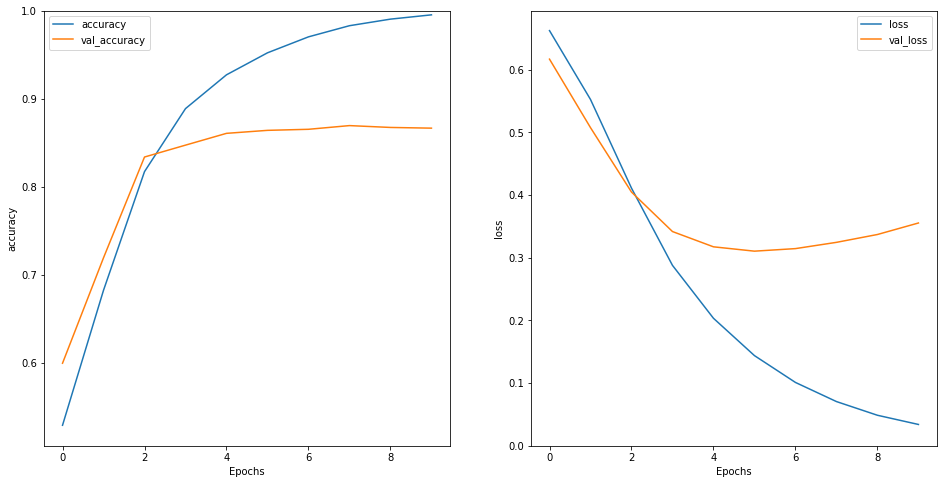

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_1, 'loss')
plt.ylim(0, None)

results_1 = model_1.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model_1.metrics_names, results_1):
  print("%s: %.3f" % (name, value))

In [ ]:
#@title Choose embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2" #@param ["https://tfhub.dev/google/nnlm-en-dim50/2", "https://tfhub.dev/google/nnlm-en-dim128/2 ", "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", "https://tfhub.dev/google/universal-sentence-encoder/4"]
print('You selected',embedding )

You selected https://tfhub.dev/google/nnlm-en-dim128/2


In [ ]:
hub_layer_2 = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model_2 = tf.keras.Sequential()
model_2.add(hub_layer_2)
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dense(1))
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_2 = model_2.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 5s 136ms/step - loss: 0.6217 - accuracy: 0.5737 - val_loss: 0.5290 - val_accuracy: 0.7323
Epoch 2/10
30/30 [==============================] - 5s 134ms/step - loss: 0.4203 - accuracy: 0.8101 - val_loss: 0.3763 - val_accuracy: 0.8468
Epoch 3/10
30/30 [==============================] - 4s 131ms/step - loss: 0.2576 - accuracy: 0.8997 - val_loss: 0.3108 - val_accuracy: 0.8660
Epoch 4/10
30/30 [==============================] - 5s 134ms/step - loss: 0.1566 - accuracy: 0.9481 - val_loss: 0.2986 - val_accuracy: 0.8711
Epoch 5/10
30/30 [==============================] - 5s 133ms/step - loss: 0.0898 - accuracy: 0.9753 - val_loss: 0.3106 - val_accuracy: 0.8775
Epoch 6/10
30/30 [==============================] - 5s 133ms/step - loss: 0.0487 - accuracy: 0.9905 - val_loss: 0.3330 - val_accuracy: 0.8710
Epoch 7/10
30/30 [==============================] - 5s 135ms/step - loss: 0.0262 - accuracy: 0.9969 - val_loss: 0.3608 - val_accuracy: 0.8717
Epoch 

49/49 - 2s - loss: 0.4822 - accuracy: 0.8524
loss: 0.482
accuracy: 0.852


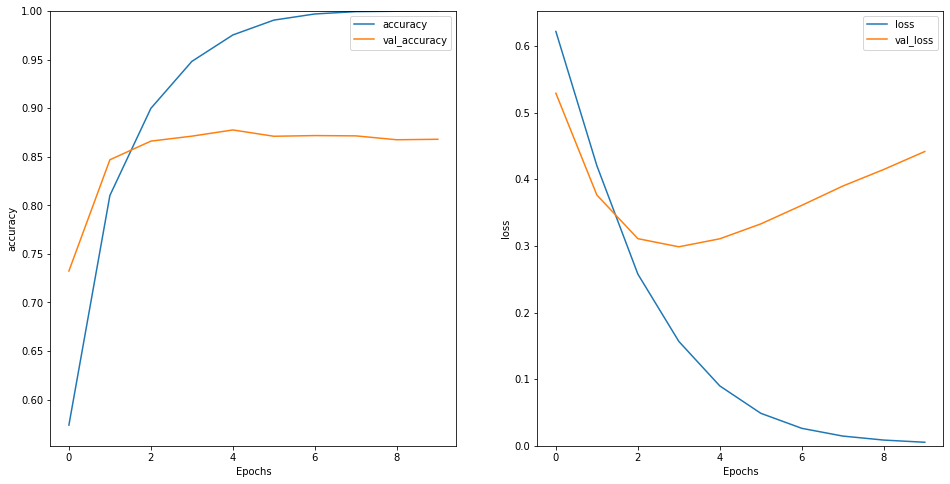

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_2, 'loss')
plt.ylim(0, None)

results_2 = model_2.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model_2.metrics_names, results_2):
  print("%s: %.3f" % (name, value))

In [ ]:
#@title Choose embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2" #@param ["https://tfhub.dev/google/nnlm-en-dim50/2", "https://tfhub.dev/google/nnlm-en-dim128/2 ", "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", "https://tfhub.dev/google/universal-sentence-encoder/4"]
print('You selected',embedding )

You selected https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2


In [ ]:
hub_layer_3 = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model_3 = tf.keras.Sequential()
model_3.add(hub_layer_3)
model_3.add(tf.keras.layers.Dense(32, activation='relu'))
model_3.add(tf.keras.layers.Dense(1))
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_3 = model_3.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 5s 146ms/step - loss: 0.6125 - accuracy: 0.5841 - val_loss: 0.5125 - val_accuracy: 0.7311
Epoch 2/10
30/30 [==============================] - 5s 144ms/step - loss: 0.3997 - accuracy: 0.8235 - val_loss: 0.3471 - val_accuracy: 0.8543
Epoch 3/10
30/30 [==============================] - 5s 143ms/step - loss: 0.2384 - accuracy: 0.9117 - val_loss: 0.2833 - val_accuracy: 0.8837
Epoch 4/10
30/30 [==============================] - 5s 144ms/step - loss: 0.1490 - accuracy: 0.9484 - val_loss: 0.2678 - val_accuracy: 0.8916
Epoch 5/10
30/30 [==============================] - 5s 143ms/step - loss: 0.0924 - accuracy: 0.9747 - val_loss: 0.2672 - val_accuracy: 0.8913
Epoch 6/10
30/30 [==============================] - 5s 146ms/step - loss: 0.0573 - accuracy: 0.9878 - val_loss: 0.2770 - val_accuracy: 0.8898
Epoch 7/10
30/30 [==============================] - 5s 145ms/step - loss: 0.0350 - accuracy: 0.9945 - val_loss: 0.2917 - val_accuracy: 0.8890
Epoch 

49/49 - 3s - loss: 0.3888 - accuracy: 0.8685
loss: 0.389
accuracy: 0.869


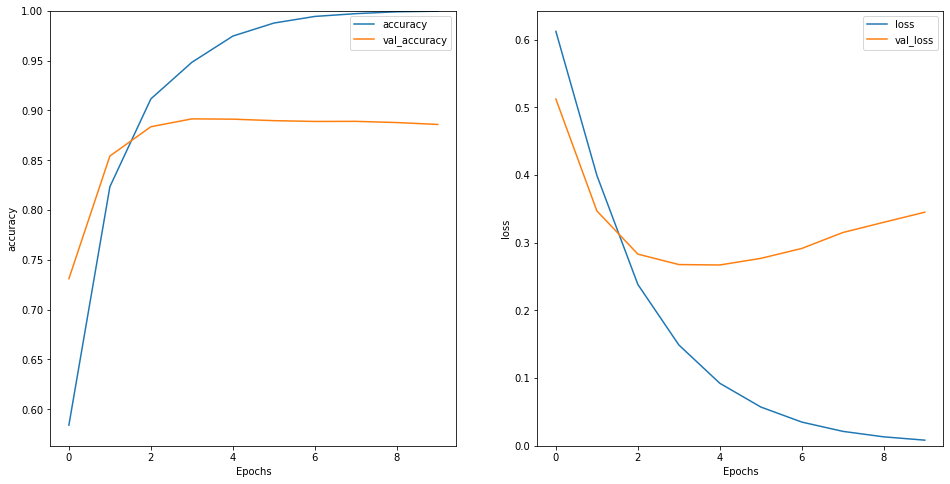

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_3, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_3, 'loss')
plt.ylim(0, None)

results_3 = model_3.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model_3.metrics_names, results_3):
  print("%s: %.3f" % (name, value))

In [ ]:
#@title Choose embedding
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/nnlm-en-dim50/2", "https://tfhub.dev/google/nnlm-en-dim128/2 ", "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2", "https://tfhub.dev/google/universal-sentence-encoder/4"]
print('You selected',embedding )

You selected https://tfhub.dev/google/universal-sentence-encoder/4


In [ ]:
hub_layer_4 = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model_4 = tf.keras.Sequential()
model_4.add(hub_layer_4)
model_4.add(tf.keras.layers.Dense(32, activation='relu'))
model_4.add(tf.keras.layers.Dense(1))
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_7 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 256,814,273
Trainable params: 256,814,273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_4 = model_4.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 42s 1s/step - loss: 0.5554 - accuracy: 0.6719 - val_loss: 0.3973 - val_accuracy: 0.8401
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 0.2591 - accuracy: 0.9069 - val_loss: 0.2940 - val_accuracy: 0.8827
Epoch 3/10
30/30 [==============================] - 36s 1s/step - loss: 0.0755 - accuracy: 0.9821 - val_loss: 0.2908 - val_accuracy: 0.8860
Epoch 4/10
30/30 [==============================] - 35s 1s/step - loss: 0.0205 - accuracy: 0.9968 - val_loss: 0.4256 - val_accuracy: 0.8745
Epoch 5/10
30/30 [==============================] - 36s 1s/step - loss: 0.0089 - accuracy: 0.9993 - val_loss: 0.4112 - val_accuracy: 0.8858
Epoch 6/10
30/30 [==============================] - 36s 1s/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.3866 - val_accuracy: 0.8815
Epoch 7/10
30/30 [==============================] - 36s 1s/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.3963 - val_accuracy: 0.8881
Epoch 8/10
30/30 [==

49/49 - 30s - loss: 0.4702 - accuracy: 0.8825
loss: 0.470
accuracy: 0.882


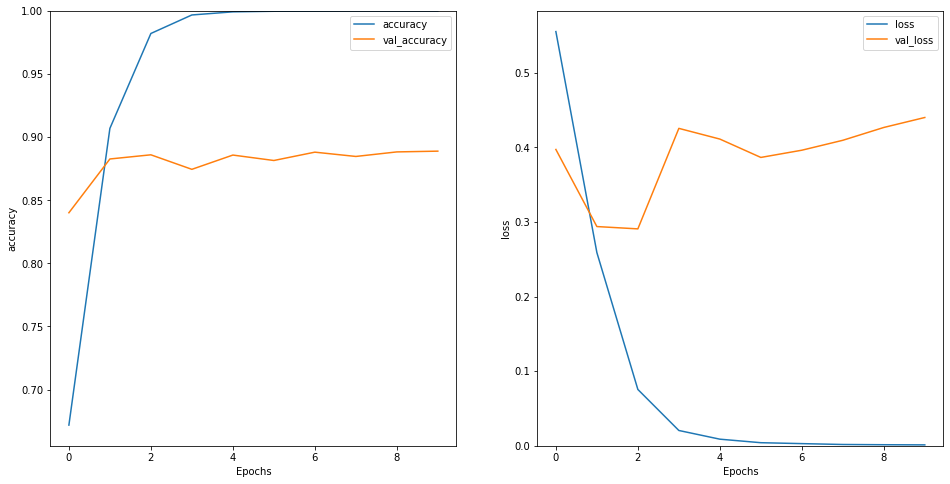

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_4, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_4, 'loss')
plt.ylim(0, None)

results_4 = model_4.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model_4.metrics_names, results_4):
  print("%s: %.3f" % (name, value))

**Conclusion:** The results are very similar for all models.

### BERT


We will take a different approach and see how BERT handles the task.

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.4,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 15000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.4,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 10000 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


We split the data in the same way as before.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(f'Example: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Example: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Example: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as th

In [ ]:
#@title Choose BERT model

bert_model_name = 'small_bert/bert_en_uncased_L-6_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**Some suggestions for choosing a model**       
- Start with a *Small BERT* since they are faster to fine-tune.      
- *ALBERT* might be a good choice if you want a small model but with higher accuracy.       
- Classic *BERT* sizes or their recent refinements like *Electra, Talking Heads, BERT Expert* will have the highest accuracy.

**Preprocessing model**       
TensorFlow Hub provides a matching preprocessing model for each of the BERT models above, which implements the following transformation: text inputs are transformed to numeric token ids and arranged in several Tensors.

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

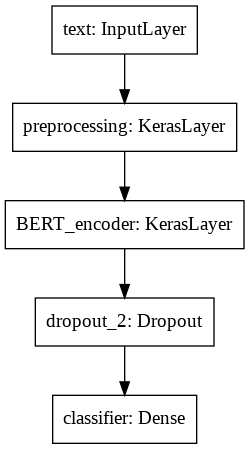

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1
Epoch 1/5
469/469 [==============================] - 207s 422ms/step - loss: 0.5003 - binary_accuracy: 0.7325 - val_loss: 0.3777 - val_binary_accuracy: 0.8319
Epoch 2/5
469/469 [==============================] - 186s 396ms/step - loss: 0.3189 - binary_accuracy: 0.8580 - val_loss: 0.4138 - val_binary_accuracy: 0.8406
Epoch 3/5
469/469 [==============================] - 185s 395ms/step - loss: 0.2305 - binary_accuracy: 0.9063 - val_loss: 0.4204 - val_binary_accuracy: 0.8423
Epoch 4/5
469/469 [==============================] - 185s 395ms/step - loss: 0.1582 - binary_accuracy: 0.9411 - val_loss: 0.5375 - val_binary_accuracy: 0.8441
Epoch 5/5
469/469 [==============================] - 186s 396ms/step - loss: 0.1131 - binary_accuracy: 0.9609 - val_loss: 0.5476 - val_binary_accuracy: 0.8476


After only 5 epochs we have almost as good results as for embedding models.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 112s 143ms/step - loss: 0.5115 - binary_accuracy: 0.8555
Loss: 0.511516809463501
Accuracy: 0.8554800152778625


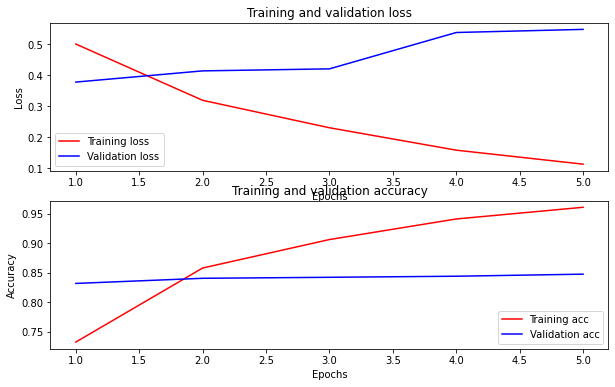

In [ ]:
history_dict = history.history
# print(history_dict.keys())
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Summary

Despite the use of two different methods, the results are very similar. Both the Embedding and BERT models are good for sentiment analysis. Compared to our modified project from the Machine Learning course, we conclude that the classical ML models are slightly worse than advanced DL. On the other hand, they are easy to interpret. Hence, it is the user's decision which method to choose depending on what he wants to achieve.